In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as random
from scipy.signal import convolve
import scipy
from joblib import Parallel, delayed
import time
from scipy import sparse
from tqdm import tqdm, tqdm_notebook

%run ../Scripts/immunity.py
%run ../Scripts/initMethods.py

In [22]:
params = { #parameters relevant for the equations
    "Nh":         100000000,
    "N0":           1000000,
    "M":                1, #Also L, total number of spacers
    }
sim_params = { #parameters relevant for the simulation (including Inital Valuess)
    "xdomain":                    100,
    "dx":                           1,
    "initial_mean_n":           [0,-40],
    "initial_var_n":               100,
    "initial_mean_nh":         [0,40],
    "initial_var_nh":              100,
    "num_threads":                  4,
    "tail_axis":               [1, 1],
    }

In [ ]:
nh0 = init_guassian(params["Nh"], sim_params, "nh")

n0 = init_guassian(params["N0"], sim_params, "n")

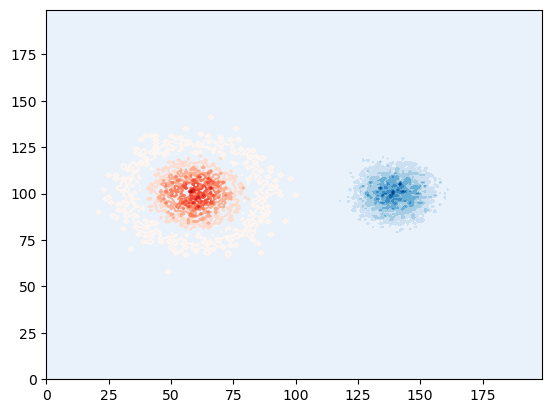

In [4]:
plt.contour(nh.todense(), cmap="Reds")
plt.contourf(n.todense(), cmap="Blues")
plt.show()

In [34]:
Nh = params["Nh"]
N = np.sum(n0)
num_threads = sim_params["num_threads"]
nh = nh0 + n0
num_to_remove = int(np.sum(nh) - Nh)

In [35]:
nonzero_indices = np.nonzero(nh)
nonzero_values = [nh[index] for index in zip(*nonzero_indices)]
index_nonzero_w_repeats = []
for value, index in zip(nonzero_values, zip(*nonzero_indices)):
    for i in range(int(value)):
        index_nonzero_w_repeats.append(index)

In [33]:
sample_flat_ind = np.random.choice(len(index_nonzero_w_repeats), num_to_remove,replace = False)

ind_per_thread_list = np.array_split(sample_flat_ind, num_threads)

def remove_points(flat_index):
    array = scipy.sparse.dok_matrix(nh.shape, dtype=int)
    sample_ind = [index_nonzero_w_repeats[i] for i in flat_index]
    for x,y in sample_ind:
        array[x, y] -= 1

    return array

results = remove_points(sample_flat_ind)

nh = nh + np.sum(results, axis=0)

In [32]:
sample_flat_ind = np.random.choice(len(index_nonzero_w_repeats), num_to_remove,replace = False)

ind_per_thread_list = np.array_split(sample_flat_ind, num_threads)

def remove_points(flat_index):
    array = scipy.sparse.dok_matrix(nh.shape, dtype=int)
    sample_ind = [index_nonzero_w_repeats[i] for i in flat_index]
    for x,y in sample_ind:
        array[x, y] -= 1

    return array

results = Parallel(n_jobs=num_threads)(
    delayed(remove_points)(flat_index) for flat_index in ind_per_thread_list)
nh = nh + np.sum(results, axis=0)

In [121]:
nonzero_indices = np.transpose(nh.nonzero())
nonzero_indices_subset = np.array_split(nonzero_indices, num_threads, axis=0)
nonzero_values = nh[nonzero_indices[:, 0], nonzero_indices[:, 1]].toarray().squeeze()
nonzero_values_subset = np.array_split(nonzero_values, num_threads, axis=0)

def process_value(values, indexes):
    index_nonzero_w_repeats = []
    for value, index in zip(values, indexes):
        index_nonzero_w_repeats.extend([index for _ in range(int(value))])

    return index_nonzero_w_repeats

results = Parallel(n_jobs=num_threads)(delayed(process_value)(values, indexes)
                              for values, indexes in zip(nonzero_values_subset, nonzero_indices_subset))

index_nonzero_w_repeats = []
for sublist in results:
    index_nonzero_w_repeats.extend(sublist)

In [106]:
set_num_to_remove = [num_to_remove//num_threads for _ in range(num_threads)]
set_num_to_remove.append(num_to_remove%num_threads)

In [134]:
num_threads = 4
total_number = np.sum(nh)
# set_index_w_repeats = np.array_split(index_nonzero_w_repeats, num_threads, axis=0)
set_num_to_remove = [int(num_to_remove*(len(res)/total_number)) for res in results]
set_num_to_remove_ex = num_to_remove - np.sum(set_num_to_remove)

In [135]:
set_num_to_remove_ex

1

In [136]:
nh_new = immunity_update(nh0, n0, params, sim_params)

immunity_update took 00:00:34


In [149]:
%run ../Scripts/immunity.py

In [150]:
nh_new2 = immunity_update_split_choice(nh0, n0, params, sim_params)